In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "resnet_ce_mse"
ood = "0:1:2:3:4"

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                            | 0/50000 [00:00<?, ?it/s]

  9%|█████▍                                                        | 4431/50000 [00:00<00:01, 44300.22it/s]

 18%|██████████▉                                                   | 8862/50000 [00:00<00:00, 42407.32it/s]

 27%|████████████████▎                                            | 13322/50000 [00:00<00:00, 43382.80it/s]

 35%|█████████████████████▌                                       | 17666/50000 [00:00<00:00, 43005.50it/s]

 44%|███████████████████████████                                  | 22136/50000 [00:00<00:00, 43605.70it/s]

 53%|████████████████████████████████▍                            | 26605/50000 [00:00<00:00, 43969.93it/s]

 62%|█████████████████████████████████████▊                       | 31005/50000 [00:00<00:00, 42969.00it/s]

 71%|███████████████████████████████████████████▎                 | 35462/50000 [00:00<00:00, 43465.57it/s]

 80%|████████████████████████████████████████████████▋            | 39953/50000 [00:00<00:00, 43909.64it/s]

 89%|██████████████████████████████████████████████████████       | 44348/50000 [00:01<00:00, 42987.32it/s]

 97%|███████████████████████████████████████████████████████████▎ | 48653/50000 [00:01<00:00, 42407.08it/s]

100%|█████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 43017.18it/s]

Files already downloaded and verified


  0%|                                                                            | 0/10000 [00:00<?, ?it/s]

 41%|█████████████████████████▏                                    | 4056/10000 [00:00<00:00, 40557.14it/s]

 81%|██████████████████████████████████████████████████▎           | 8112/10000 [00:00<00:00, 40535.48it/s]

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 41141.12it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 ks6467y3


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-ks6467y3:best, 58.56MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.2


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    fpi = 5

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            rcn = x
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        rcn = x
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/625 [00:00<?, ?it/s]

  0%|                                                                      | 1/625 [00:00<05:20,  1.95it/s]

  1%|▊                                                                     | 7/625 [00:00<00:43, 14.24it/s]

  2%|█▍                                                                   | 13/625 [00:00<00:25, 24.18it/s]

  3%|██▏                                                                  | 20/625 [00:00<00:17, 34.64it/s]

  4%|██▉                                                                  | 27/625 [00:00<00:13, 42.72it/s]

  5%|███▊                                                                 | 34/625 [00:01<00:12, 48.78it/s]

  7%|████▌                                                                | 41/625 [00:01<00:10, 53.25it/s]

  8%|█████▎                                                               | 48/625 [00:01<00:10, 56.51it/s]

  9%|██████                                                               | 55/625 [00:01<00:09, 58.85it/s]

 10%|██████▊                                                              | 62/625 [00:01<00:09, 60.49it/s]

 11%|███████▌                                                             | 69/625 [00:01<00:09, 61.69it/s]

 12%|████████▍                                                            | 76/625 [00:01<00:08, 62.54it/s]

 13%|█████████▏                                                           | 83/625 [00:01<00:08, 63.12it/s]

 14%|█████████▉                                                           | 90/625 [00:01<00:08, 63.57it/s]

 16%|██████████▋                                                          | 97/625 [00:02<00:08, 63.90it/s]

 17%|███████████▎                                                        | 104/625 [00:02<00:08, 64.14it/s]

 18%|████████████                                                        | 111/625 [00:02<00:07, 64.31it/s]

 19%|████████████▊                                                       | 118/625 [00:02<00:07, 64.44it/s]

 20%|█████████████▌                                                      | 125/625 [00:02<00:07, 64.51it/s]

 21%|██████████████▎                                                     | 132/625 [00:02<00:07, 64.59it/s]

 22%|███████████████                                                     | 139/625 [00:02<00:07, 64.62it/s]

 23%|███████████████▉                                                    | 146/625 [00:02<00:07, 64.61it/s]

 24%|████████████████▋                                                   | 153/625 [00:02<00:07, 64.59it/s]

 26%|█████████████████▍                                                  | 160/625 [00:03<00:07, 64.61it/s]

 27%|██████████████████▏                                                 | 167/625 [00:03<00:07, 64.65it/s]

 28%|██████████████████▉                                                 | 174/625 [00:03<00:06, 64.66it/s]

 29%|███████████████████▋                                                | 181/625 [00:03<00:06, 64.69it/s]

 30%|████████████████████▍                                               | 188/625 [00:03<00:06, 64.72it/s]

 31%|█████████████████████▏                                              | 195/625 [00:03<00:06, 64.73it/s]

 32%|█████████████████████▉                                              | 202/625 [00:03<00:06, 64.71it/s]

 33%|██████████████████████▋                                             | 209/625 [00:03<00:06, 64.74it/s]

 35%|███████████████████████▌                                            | 216/625 [00:03<00:06, 64.76it/s]

 36%|████████████████████████▎                                           | 223/625 [00:03<00:06, 64.73it/s]

 37%|█████████████████████████                                           | 230/625 [00:04<00:06, 64.54it/s]

 38%|█████████████████████████▊                                          | 237/625 [00:04<00:06, 64.57it/s]

 39%|██████████████████████████▌                                         | 244/625 [00:04<00:05, 64.63it/s]

 40%|███████████████████████████▎                                        | 251/625 [00:04<00:05, 64.62it/s]

 41%|████████████████████████████                                        | 258/625 [00:04<00:05, 64.66it/s]

 42%|████████████████████████████▊                                       | 265/625 [00:04<00:05, 64.66it/s]

 44%|█████████████████████████████▌                                      | 272/625 [00:04<00:05, 64.64it/s]

 45%|██████████████████████████████▎                                     | 279/625 [00:04<00:05, 64.62it/s]

 46%|███████████████████████████████                                     | 286/625 [00:04<00:05, 64.59it/s]

 47%|███████████████████████████████▉                                    | 293/625 [00:05<00:05, 64.58it/s]

 48%|████████████████████████████████▋                                   | 300/625 [00:05<00:05, 64.61it/s]

 49%|█████████████████████████████████▍                                  | 307/625 [00:05<00:04, 64.61it/s]

 50%|██████████████████████████████████▏                                 | 314/625 [00:05<00:04, 64.59it/s]

 51%|██████████████████████████████████▉                                 | 321/625 [00:05<00:04, 64.56it/s]

 52%|███████████████████████████████████▋                                | 328/625 [00:05<00:04, 64.55it/s]

 54%|████████████████████████████████████▍                               | 335/625 [00:05<00:04, 64.55it/s]

 55%|█████████████████████████████████████▏                              | 342/625 [00:05<00:04, 64.56it/s]

 56%|█████████████████████████████████████▉                              | 349/625 [00:05<00:04, 64.60it/s]

 57%|██████████████████████████████████████▋                             | 356/625 [00:06<00:04, 64.62it/s]

 58%|███████████████████████████████████████▍                            | 363/625 [00:06<00:04, 64.61it/s]

 59%|████████████████████████████████████████▎                           | 370/625 [00:06<00:03, 64.61it/s]

 60%|█████████████████████████████████████████                           | 377/625 [00:06<00:03, 64.63it/s]

 61%|█████████████████████████████████████████▊                          | 384/625 [00:06<00:03, 64.68it/s]

 63%|██████████████████████████████████████████▌                         | 391/625 [00:06<00:03, 64.69it/s]

 64%|███████████████████████████████████████████▎                        | 398/625 [00:06<00:03, 64.70it/s]

 65%|████████████████████████████████████████████                        | 405/625 [00:06<00:03, 64.67it/s]

 66%|████████████████████████████████████████████▊                       | 412/625 [00:06<00:03, 64.69it/s]

 67%|█████████████████████████████████████████████▌                      | 419/625 [00:07<00:03, 64.71it/s]

 68%|██████████████████████████████████████████████▎                     | 426/625 [00:07<00:03, 64.71it/s]

 69%|███████████████████████████████████████████████                     | 433/625 [00:07<00:02, 64.71it/s]

 70%|███████████████████████████████████████████████▊                    | 440/625 [00:07<00:02, 64.73it/s]

 72%|████████████████████████████████████████████████▋                   | 447/625 [00:07<00:02, 64.74it/s]

 73%|█████████████████████████████████████████████████▍                  | 454/625 [00:07<00:02, 64.68it/s]

 74%|██████████████████████████████████████████████████▏                 | 461/625 [00:07<00:02, 64.73it/s]

 75%|██████████████████████████████████████████████████▉                 | 468/625 [00:07<00:02, 64.72it/s]

 76%|███████████████████████████████████████████████████▋                | 475/625 [00:07<00:02, 64.71it/s]

 77%|████████████████████████████████████████████████████▍               | 482/625 [00:07<00:02, 64.71it/s]

 78%|█████████████████████████████████████████████████████▏              | 489/625 [00:08<00:02, 64.67it/s]

 79%|█████████████████████████████████████████████████████▉              | 496/625 [00:08<00:02, 64.38it/s]

 80%|██████████████████████████████████████████████████████▋             | 503/625 [00:08<00:01, 64.49it/s]

 82%|███████████████████████████████████████████████████████▍            | 510/625 [00:08<00:01, 64.49it/s]

 83%|████████████████████████████████████████████████████████▏           | 517/625 [00:08<00:01, 64.63it/s]

 84%|█████████████████████████████████████████████████████████           | 524/625 [00:08<00:01, 64.68it/s]

 85%|█████████████████████████████████████████████████████████▊          | 531/625 [00:08<00:01, 64.71it/s]

 86%|██████████████████████████████████████████████████████████▌         | 538/625 [00:08<00:01, 64.72it/s]

 87%|███████████████████████████████████████████████████████████▎        | 545/625 [00:08<00:01, 64.74it/s]

 88%|████████████████████████████████████████████████████████████        | 552/625 [00:09<00:01, 64.73it/s]

 89%|████████████████████████████████████████████████████████████▊       | 559/625 [00:09<00:01, 64.73it/s]

 91%|█████████████████████████████████████████████████████████████▌      | 566/625 [00:09<00:00, 64.73it/s]

 92%|██████████████████████████████████████████████████████████████▎     | 573/625 [00:09<00:00, 64.72it/s]

 93%|███████████████████████████████████████████████████████████████     | 580/625 [00:09<00:00, 64.59it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 587/625 [00:09<00:00, 64.62it/s]

 95%|████████████████████████████████████████████████████████████████▋   | 594/625 [00:09<00:00, 64.63it/s]

 96%|█████████████████████████████████████████████████████████████████▍  | 601/625 [00:09<00:00, 64.64it/s]

 97%|██████████████████████████████████████████████████████████████████▏ | 608/625 [00:09<00:00, 64.65it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 615/625 [00:10<00:00, 64.67it/s]

100%|███████████████████████████████████████████████████████████████████▋| 622/625 [00:10<00:00, 64.55it/s]

100%|████████████████████████████████████████████████████████████████████| 625/625 [00:10<00:00, 61.13it/s]

train - OK


  0%|                                                                              | 0/157 [00:00<?, ?it/s]

  1%|▉                                                                     | 2/157 [00:00<00:08, 18.60it/s]

  6%|████                                                                  | 9/157 [00:00<00:03, 45.45it/s]

 10%|███████                                                              | 16/157 [00:00<00:02, 54.12it/s]

 15%|██████████                                                           | 23/157 [00:00<00:02, 58.18it/s]

 19%|█████████████▏                                                       | 30/157 [00:00<00:02, 60.45it/s]

 24%|████████████████▎                                                    | 37/157 [00:00<00:01, 61.82it/s]

 28%|███████████████████▎                                                 | 44/157 [00:00<00:01, 62.69it/s]

 32%|██████████████████████▍                                              | 51/157 [00:00<00:01, 63.25it/s]

 37%|█████████████████████████▍                                           | 58/157 [00:00<00:01, 63.66it/s]

 41%|████████████████████████████▌                                        | 65/157 [00:01<00:01, 63.93it/s]

 46%|███████████████████████████████▋                                     | 72/157 [00:01<00:01, 64.14it/s]

 50%|██████████████████████████████████▋                                  | 79/157 [00:01<00:01, 64.28it/s]

 55%|█████████████████████████████████████▊                               | 86/157 [00:01<00:01, 64.36it/s]

 59%|████████████████████████████████████████▊                            | 93/157 [00:01<00:00, 64.44it/s]

 64%|███████████████████████████████████████████▎                        | 100/157 [00:01<00:00, 64.48it/s]

 68%|██████████████████████████████████████████████▎                     | 107/157 [00:01<00:00, 64.49it/s]

 73%|█████████████████████████████████████████████████▍                  | 114/157 [00:01<00:00, 64.54it/s]

 77%|████████████████████████████████████████████████████▍               | 121/157 [00:01<00:00, 64.55it/s]

 82%|███████████████████████████████████████████████████████▍            | 128/157 [00:02<00:00, 64.55it/s]

 86%|██████████████████████████████████████████████████████████▍         | 135/157 [00:02<00:00, 64.56it/s]

 90%|█████████████████████████████████████████████████████████████▌      | 142/157 [00:02<00:00, 64.56it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 149/157 [00:02<00:00, 64.56it/s]

 99%|███████████████████████████████████████████████████████████████████▌| 156/157 [00:02<00:00, 64.59it/s]

100%|████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 60.94it/s]

val - OK


  0%|                                                                              | 0/157 [00:00<?, ?it/s]

  1%|▍                                                                     | 1/157 [00:00<00:15,  9.95it/s]

  5%|███▌                                                                  | 8/157 [00:00<00:03, 42.81it/s]

 10%|██████▌                                                              | 15/157 [00:00<00:02, 52.82it/s]

 14%|█████████▋                                                           | 22/157 [00:00<00:02, 57.47it/s]

 18%|████████████▋                                                        | 29/157 [00:00<00:02, 60.03it/s]

 23%|███████████████▊                                                     | 36/157 [00:00<00:01, 61.59it/s]

 27%|██████████████████▉                                                  | 43/157 [00:00<00:01, 62.46it/s]

 32%|█████████████████████▉                                               | 50/157 [00:00<00:01, 63.09it/s]

 36%|█████████████████████████                                            | 57/157 [00:00<00:01, 63.48it/s]

 41%|████████████████████████████▏                                        | 64/157 [00:01<00:01, 63.78it/s]

 45%|███████████████████████████████▏                                     | 71/157 [00:01<00:01, 64.01it/s]

 50%|██████████████████████████████████▎                                  | 78/157 [00:01<00:01, 64.17it/s]

 54%|█████████████████████████████████████▎                               | 85/157 [00:01<00:01, 64.26it/s]

 59%|████████████████████████████████████████▍                            | 92/157 [00:01<00:01, 64.36it/s]

 63%|███████████████████████████████████████████▌                         | 99/157 [00:01<00:00, 64.42it/s]

 68%|█████████████████████████████████████████████▉                      | 106/157 [00:01<00:00, 64.43it/s]

 72%|████████████████████████████████████████████████▉                   | 113/157 [00:01<00:00, 64.46it/s]

 76%|███████████████████████████████████████████████████▉                | 120/157 [00:01<00:00, 64.48it/s]

 81%|███████████████████████████████████████████████████████             | 127/157 [00:02<00:00, 64.50it/s]

 85%|██████████████████████████████████████████████████████████          | 134/157 [00:02<00:00, 64.51it/s]

 90%|█████████████████████████████████████████████████████████████       | 141/157 [00:02<00:00, 64.51it/s]

 94%|████████████████████████████████████████████████████████████████    | 148/157 [00:02<00:00, 64.52it/s]

 99%|███████████████████████████████████████████████████████████████████▏| 155/157 [00:02<00:00, 64.54it/s]

100%|████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 61.55it/s]

test InD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  7%|████▉                                                                 | 7/100 [00:00<00:01, 64.28it/s]

 14%|█████████▋                                                           | 14/100 [00:00<00:01, 64.32it/s]

 21%|██████████████▍                                                      | 21/100 [00:00<00:01, 64.41it/s]

 28%|███████████████████▎                                                 | 28/100 [00:00<00:01, 64.49it/s]

 35%|████████████████████████▏                                            | 35/100 [00:00<00:01, 64.54it/s]

 42%|████████████████████████████▉                                        | 42/100 [00:00<00:00, 64.57it/s]

 49%|█████████████████████████████████▊                                   | 49/100 [00:00<00:00, 64.58it/s]

 56%|██████████████████████████████████████▋                              | 56/100 [00:00<00:00, 64.60it/s]

 63%|███████████████████████████████████████████▍                         | 63/100 [00:00<00:00, 64.63it/s]

 70%|████████████████████████████████████████████████▎                    | 70/100 [00:01<00:00, 64.64it/s]

 77%|█████████████████████████████████████████████████████▏               | 77/100 [00:01<00:00, 64.62it/s]

 84%|█████████████████████████████████████████████████████████▉           | 84/100 [00:01<00:00, 64.63it/s]

 91%|██████████████████████████████████████████████████████████████▊      | 91/100 [00:01<00:00, 64.62it/s]

 98%|███████████████████████████████████████████████████████████████████▌ | 98/100 [00:01<00:00, 64.63it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 64.54it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(40000, 3, 32, 32) (40000, 3, 32, 32) (40000, 512) (40000, 10) (40000,)
(10000, 3, 32, 32) (10000, 3, 32, 32) (10000, 512) (10000, 10) (10000,)
(10000, 3, 32, 32) (10000, 3, 32, 32) (10000, 512) (10000, 10) (10000,)
(6400, 3, 32, 32) (6400, 3, 32, 32) (6400, 512) (6400, 10)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(10000, 2) (0, 2)


(10000, 2) (0, 2)


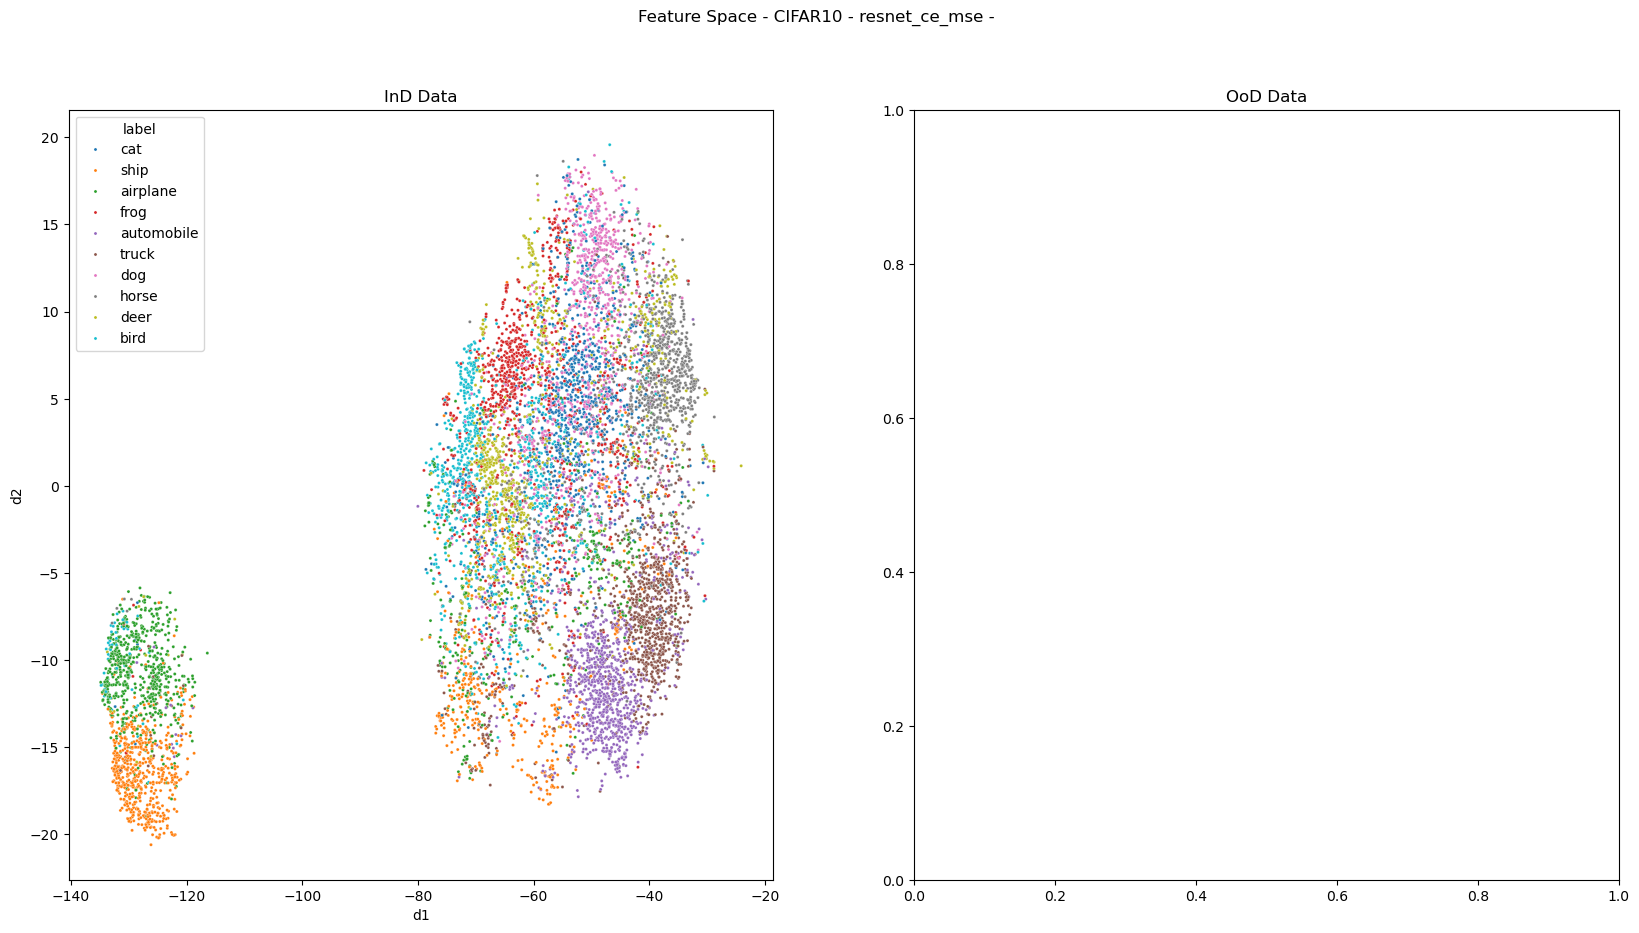

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

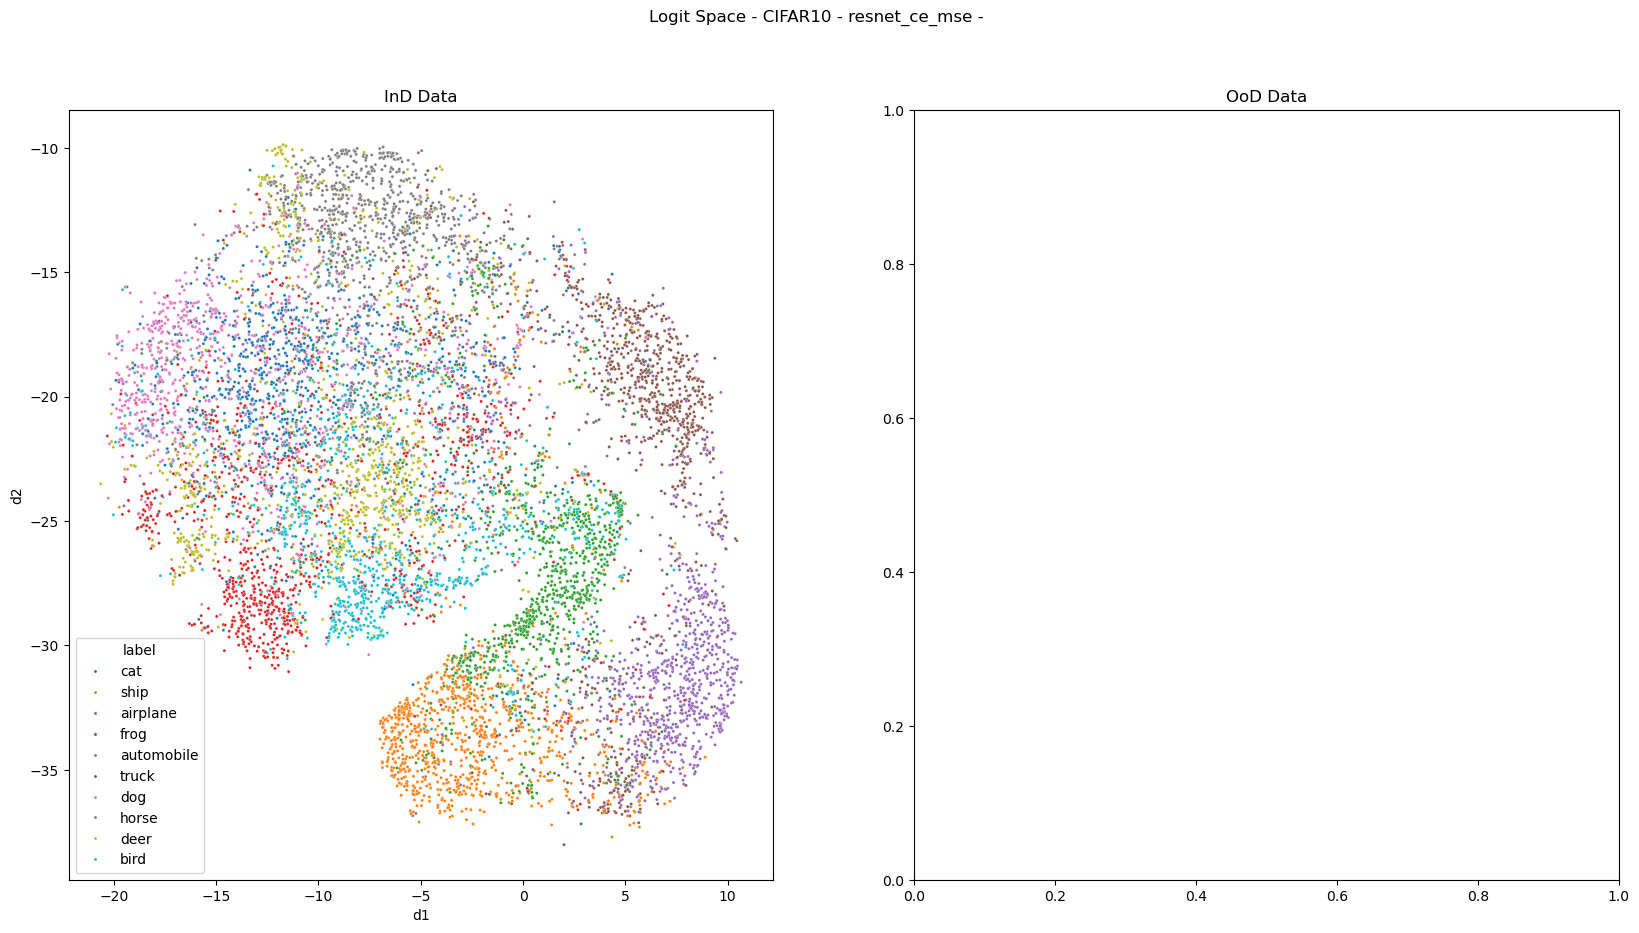

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:02,  1.28it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:01<00:01,  1.27it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:02<00:00,  1.15it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]

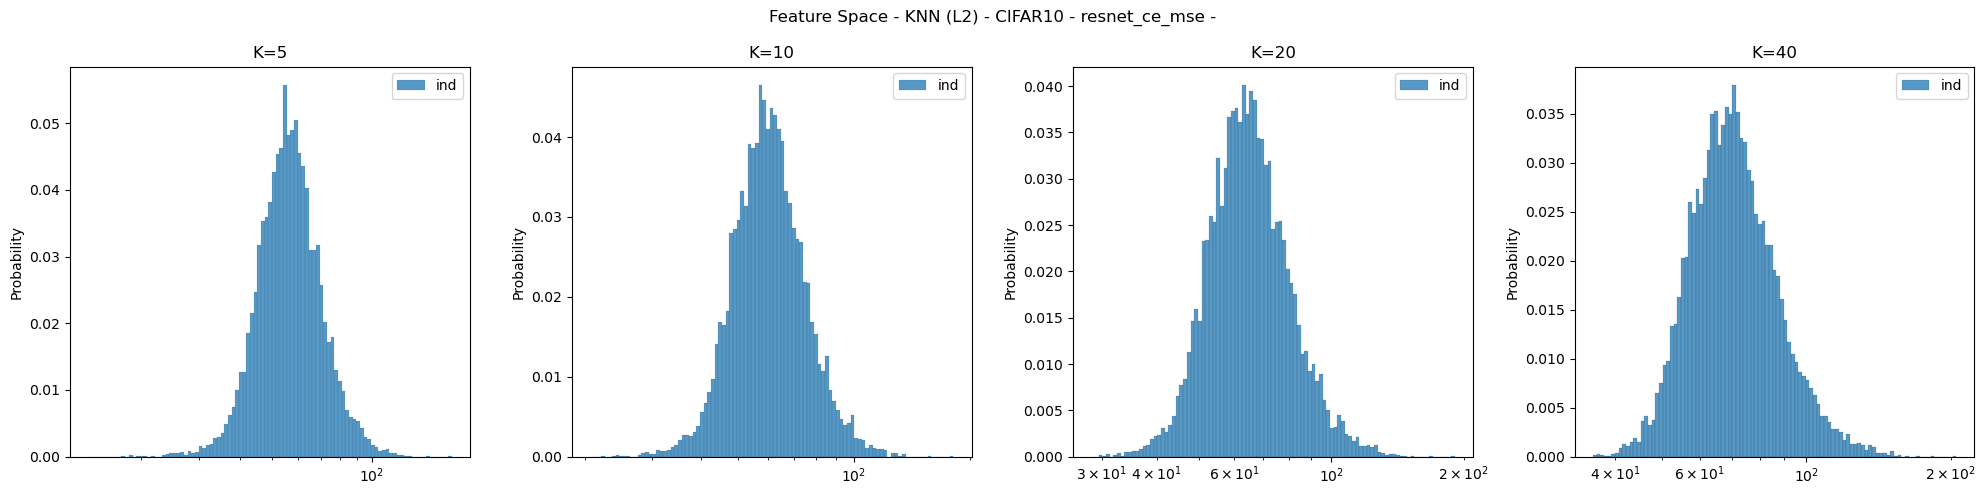

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:02,  1.31it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:01<00:01,  1.30it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:02<00:00,  1.28it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.26it/s]

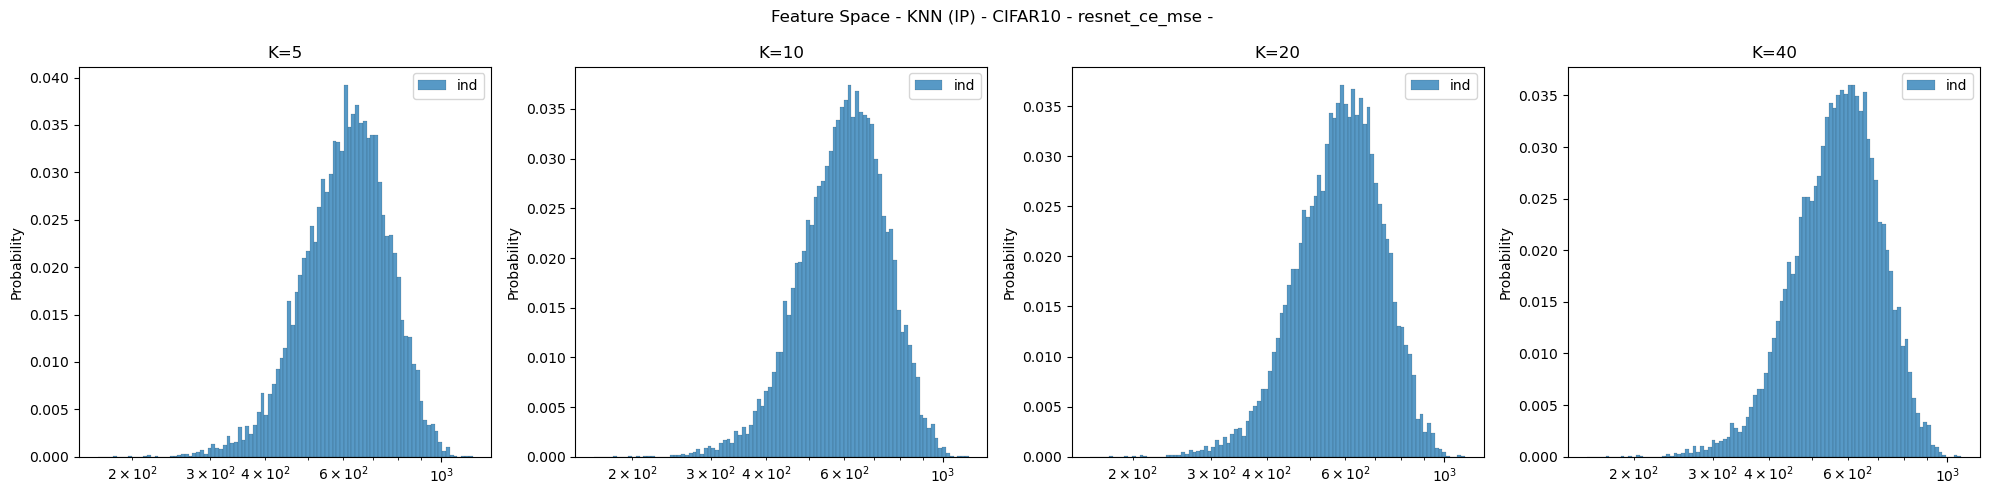

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:00,  5.77it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  5.58it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:00<00:00,  3.60it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.68it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.94it/s]

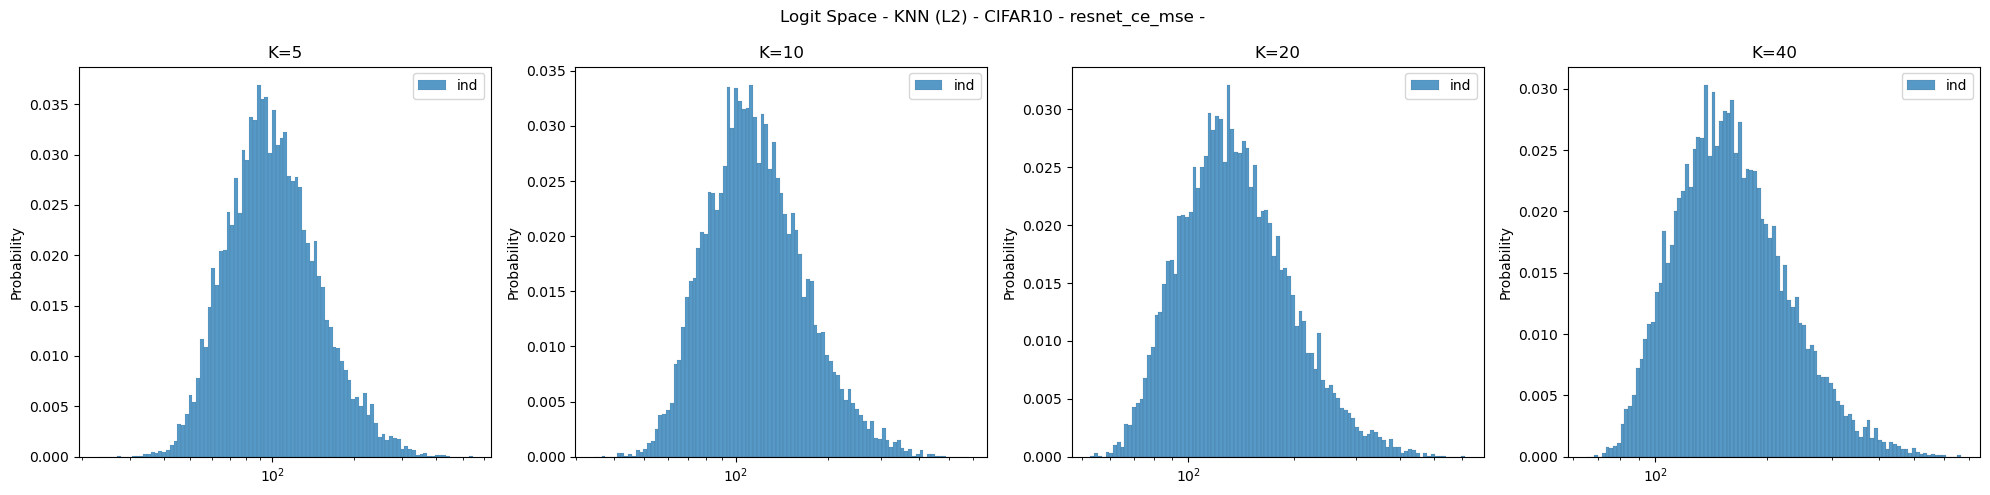

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:00,  6.31it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  6.06it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:00<00:00,  5.58it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.84it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.17it/s]

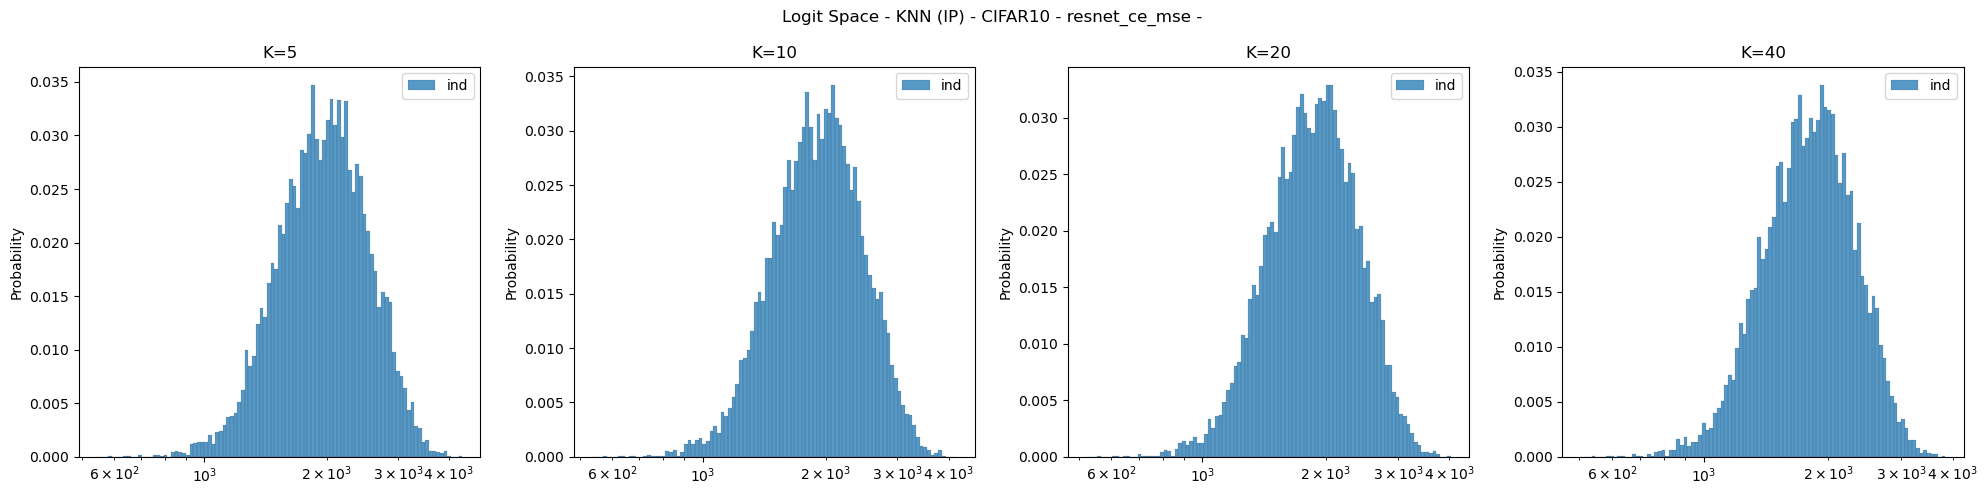

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

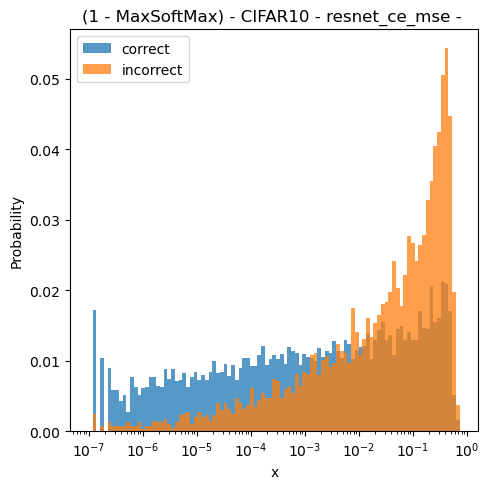

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

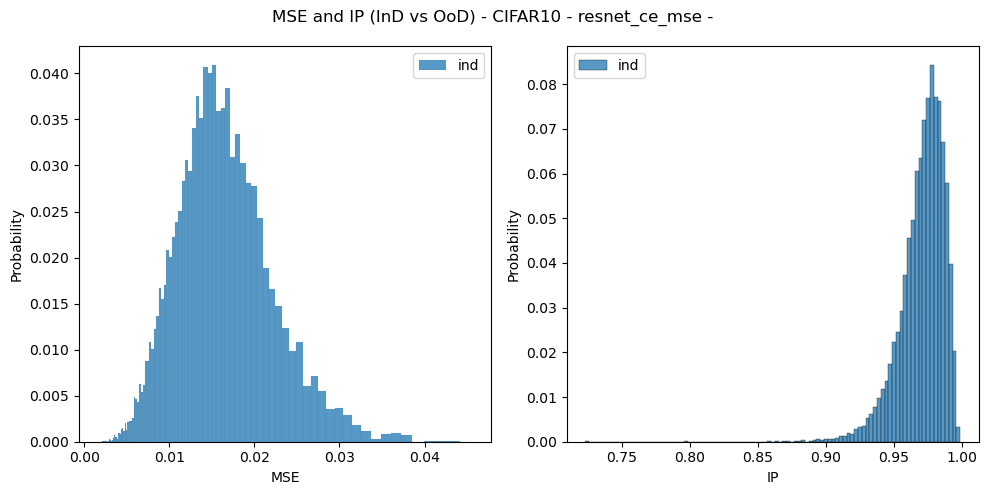

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()